In [ ]:
# import content
import zipfile,os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api._v2.keras import callbacks
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# unzip data and get data
local_zip = '/content/drive/MyDrive/Colab Notebooks/shareFolder/flower_redonefix.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()


In [ ]:
# get content files
basedir = '/content/flower_redonefix'
pathpng = basedir + '/Aster/' +'Aster-Test (1).png'
img = Image.open(pathpng)

print("The height of the image is: ", img.height)
print("The width of the image is: ", img.width)

The height of the image is:  225
The width of the image is:  225


In [ ]:
# data processing
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        basedir,
        target_size=(img.height, img.width),
        #class_mode='sparse',
        shuffle=True,
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        basedir,
        target_size=(img.height, img.width),
        #class_mode='sparse',
        subset='validation')


Found 13888 images belonging to 10 classes.
Found 3467 images belonging to 10 classes.


In [ ]:
# preparing AI and other variables


model = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(img.height, img.width, 3) ) ),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.92):
      print("\nVal Akurasi telah mencapai >92%!")
      self.model.stop_training = True
mmcallbacks = myCallback()

optimizerv = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizerv,
              metrics=['accuracy'])

In [ ]:
# BOOM!
history = model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=120,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2, callbacks=[mmcallbacks])

Epoch 1/120
20/20 - 46s - loss: 2.5553 - accuracy: 0.1688 - val_loss: 2.1611 - val_accuracy: 0.2125 - 46s/epoch - 2s/step
Epoch 2/120
20/20 - 14s - loss: 2.0463 - accuracy: 0.2922 - val_loss: 2.1476 - val_accuracy: 0.2750 - 14s/epoch - 690ms/step
Epoch 3/120
20/20 - 11s - loss: 1.8060 - accuracy: 0.3859 - val_loss: 1.9460 - val_accuracy: 0.4000 - 11s/epoch - 571ms/step
Epoch 4/120
20/20 - 12s - loss: 1.4164 - accuracy: 0.5266 - val_loss: 1.9259 - val_accuracy: 0.4125 - 12s/epoch - 606ms/step
Epoch 5/120
20/20 - 10s - loss: 1.3227 - accuracy: 0.5828 - val_loss: 1.5618 - val_accuracy: 0.5437 - 10s/epoch - 520ms/step
Epoch 6/120
20/20 - 12s - loss: 1.1451 - accuracy: 0.6203 - val_loss: 1.7144 - val_accuracy: 0.5000 - 12s/epoch - 580ms/step
Epoch 7/120
20/20 - 11s - loss: 1.1256 - accuracy: 0.6406 - val_loss: 1.4111 - val_accuracy: 0.5562 - 11s/epoch - 568ms/step
Epoch 8/120
20/20 - 13s - loss: 1.0132 - accuracy: 0.6828 - val_loss: 1.4040 - val_accuracy: 0.6062 - 13s/epoch - 633ms/step
Epo

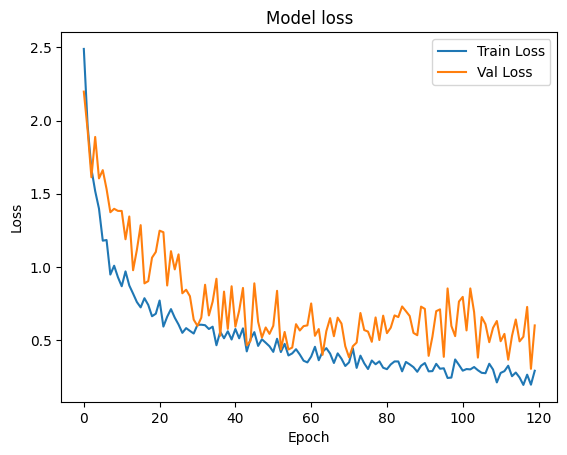

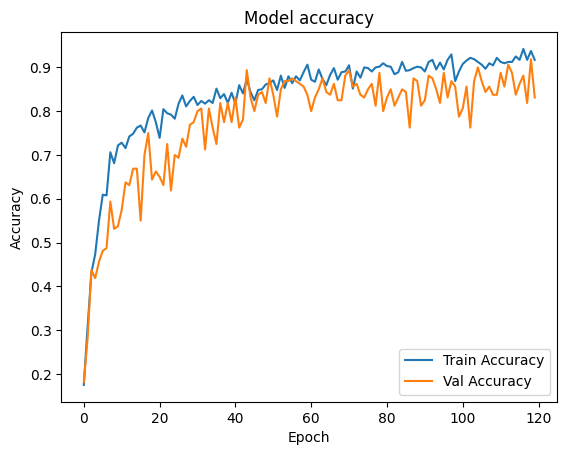

In [34]:
#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

#plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')
plt.show()

In [ ]:
# deployment???
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('rps.tflite')
tflite_model_file.write_bytes(tflite_model)

15393200